# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

Шаги для выбора локации:
В избранном регионе ищут месторождения, для каждого определяют значения признаков;
Строят модель и оценивают объём запасов;
Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
Прибыль равна суммарной прибыли отобранных месторождений.

##  Загрузка и подготовка данных

In [4]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
!pip install sweetviz -q
import sweetviz as sv

In [5]:
# загрузка датасетов
try:
    region_0 = pd.read_csv('geo_data_0.csv')
    region_1 = pd.read_csv('geo_data_1.csv')
    region_2 = pd.read_csv('geo_data_2.csv')
except:
    region_0 = pd.read_csv('/datasets/geo_data_0.csv')
    region_1 = pd.read_csv('/datasets/geo_data_1.csv')
    region_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [6]:
# обзор данных
display(region_0.head())
region_0.info()
region_1.info()
region_2.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

Представлены 3 файла, характеризующие скважины в каждом из трех регионов. Каждый файл состоит из 100 000 строк, каждая из которых характеризует скважину с точки зрения трех геологических параметров, выраженных численно. Пропусков в данных нет. Типы данных в столбцах определены верно. Для построения модели будут использованы столбцы с тремя признаками, целевым признаком является столбец "product". Столбец "id" на прогноз не влияет. Учитывая, что целевой признак - число, перед нами стоит задача регресии: нужно предсказать число на основании признаков.

In [7]:
data = pd.concat([region_0, region_1, region_2], axis=0, join="outer", ignore_index=True) # объединим регионы
display(data)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
299995,4GxBu,-1.777037,1.125220,6.263374,172.327046
299996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
299997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
299998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


In [8]:
# удаление ненужных столбцов
datasets = [data, region_0, region_1, region_2]
for d in datasets:
    d = d.drop(['id'], axis = 1, inplace=True)
display(data.head())

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


In [9]:
# выделение целевого признака и извлечение остальных
features_all = data.drop(['product'], axis=1)# извлечение признаков
target_all = data['product'] # извлечение  целевого признака
# по регионам
regions = [region_0, region_1, region_2] #список регионов
features = []
target = []
for region in regions:
    features.append(region.drop(['product'], axis=1))
    target.append(region['product'])

                                             |                                             | [  0%]   00:00 ->…


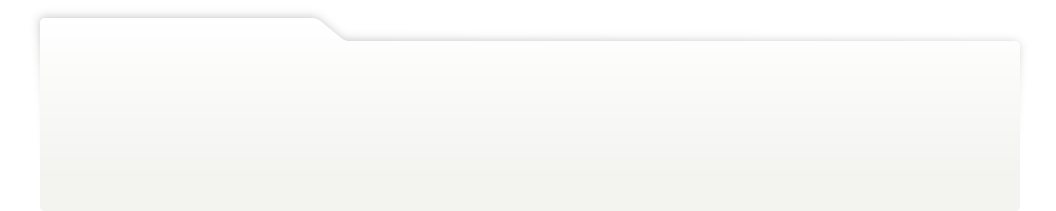
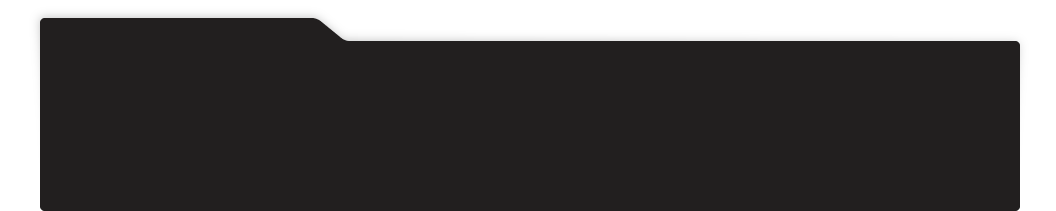
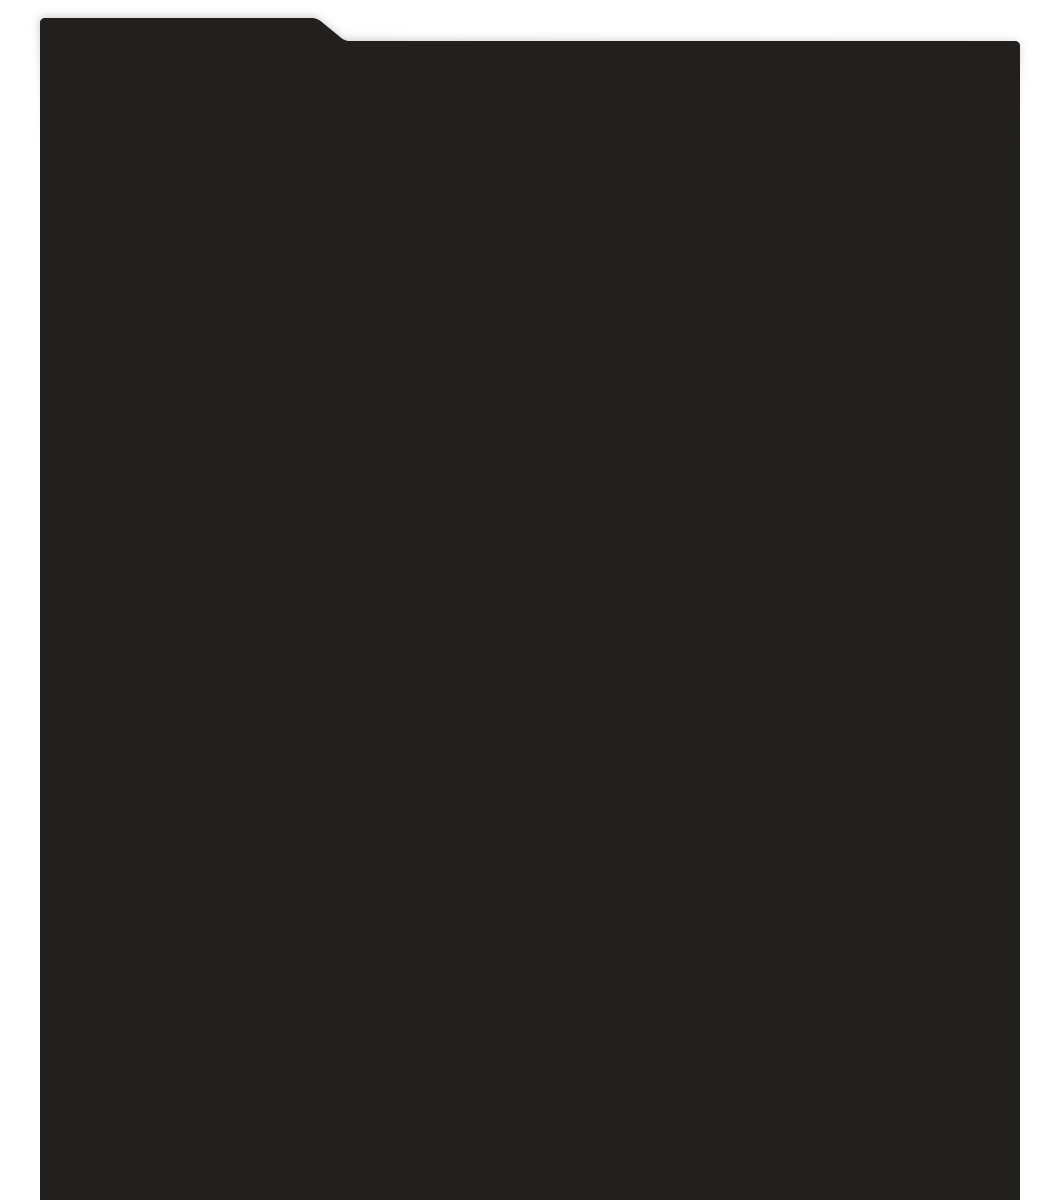
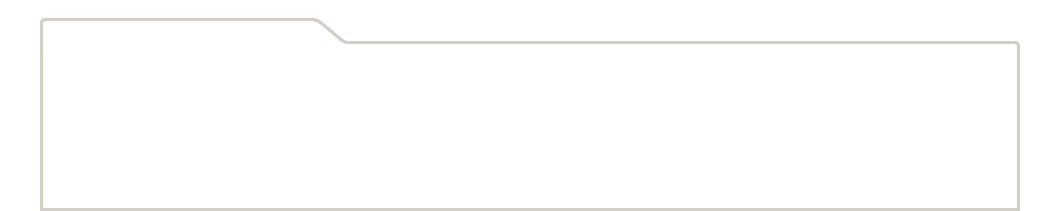
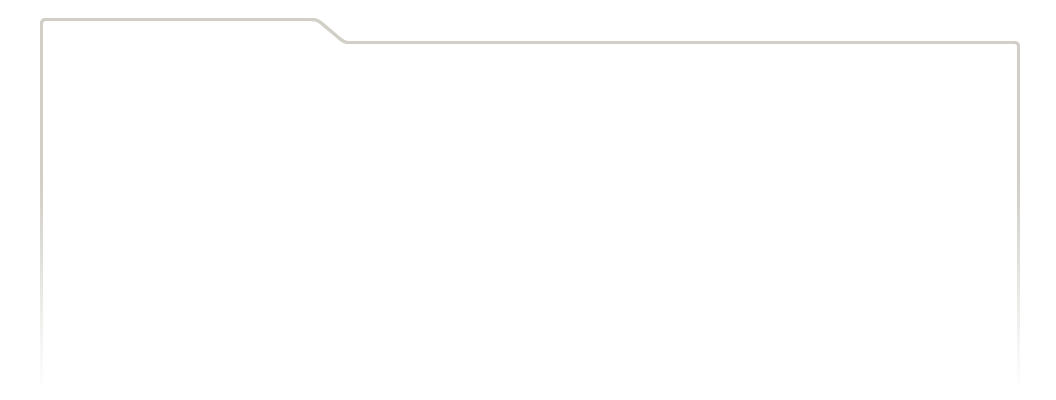
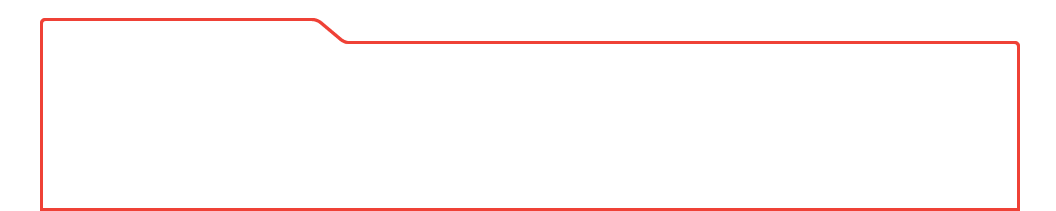
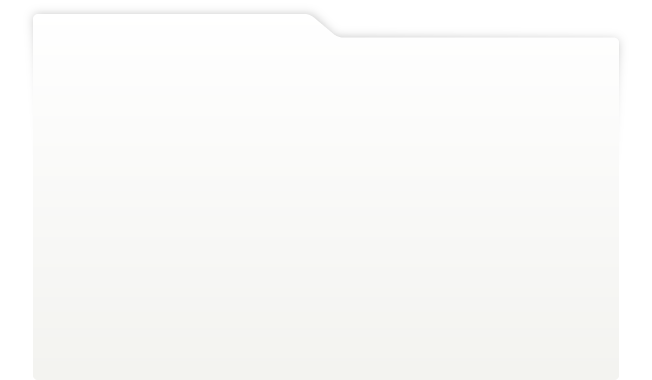
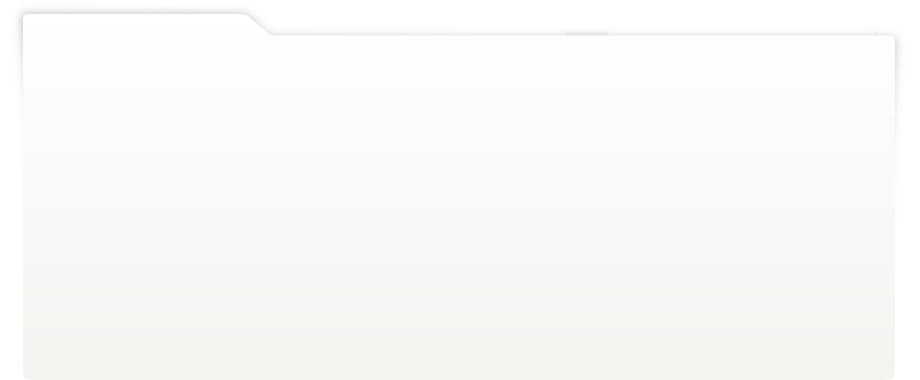
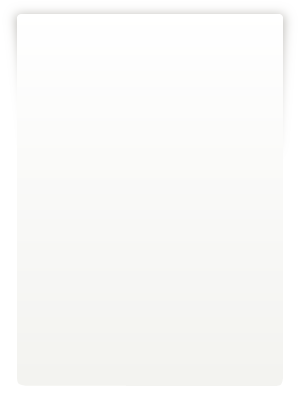
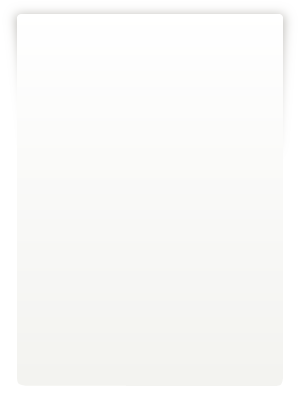
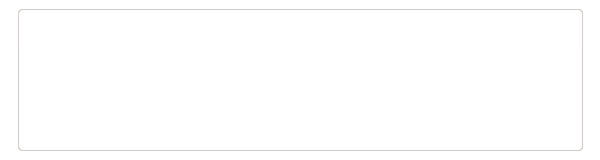
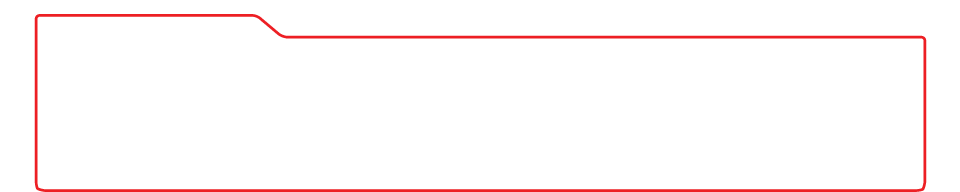
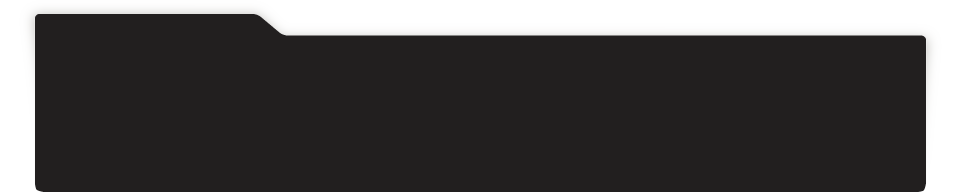
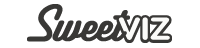
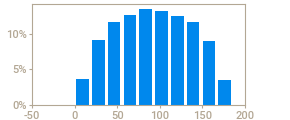
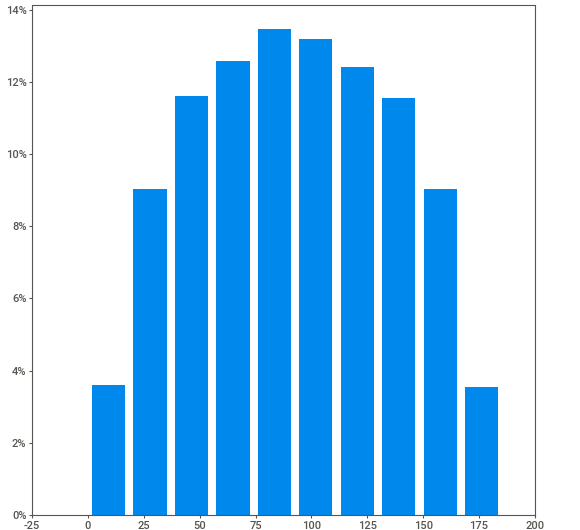
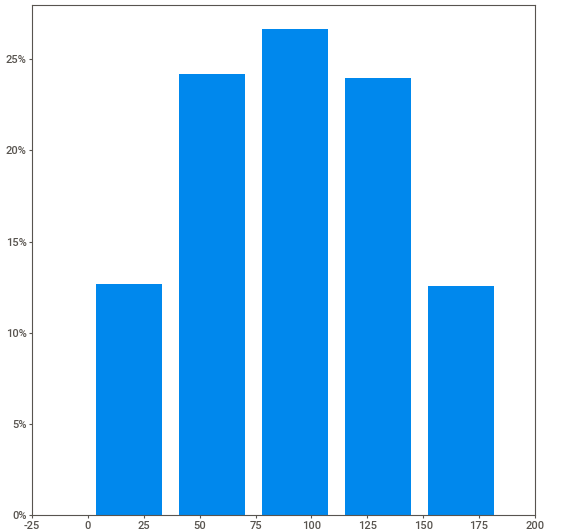
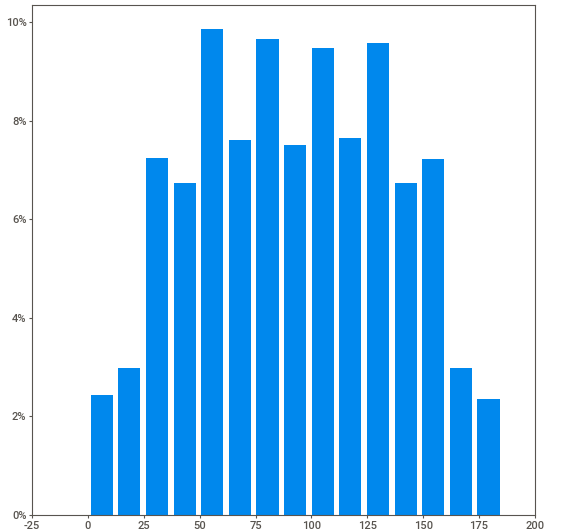
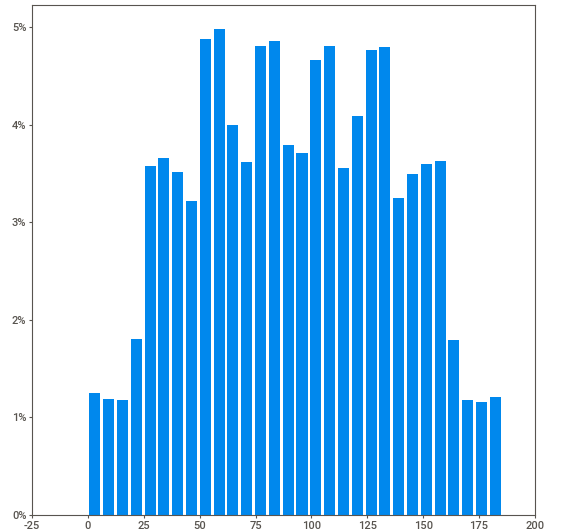
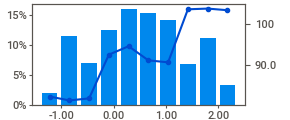
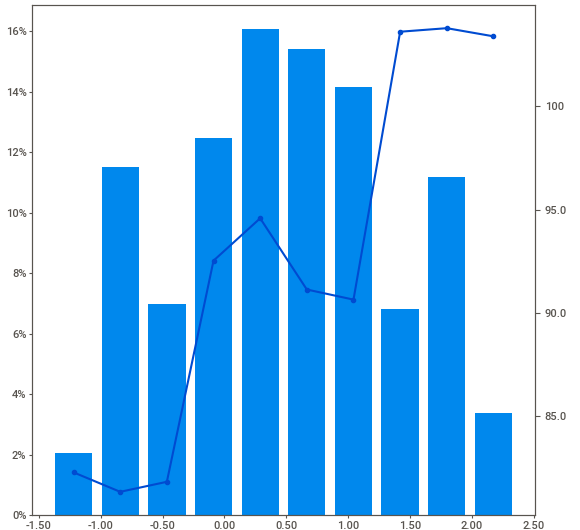
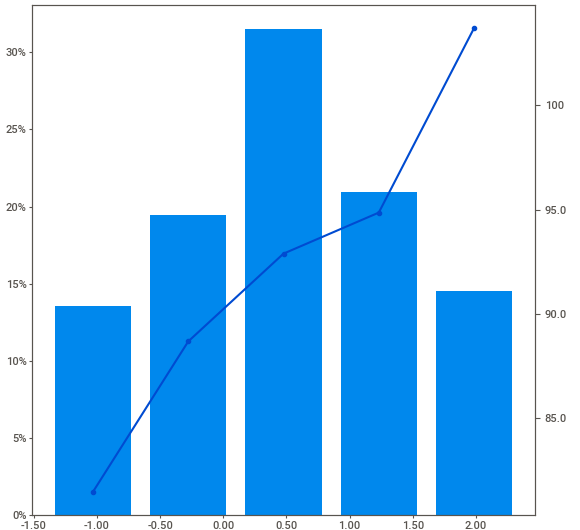
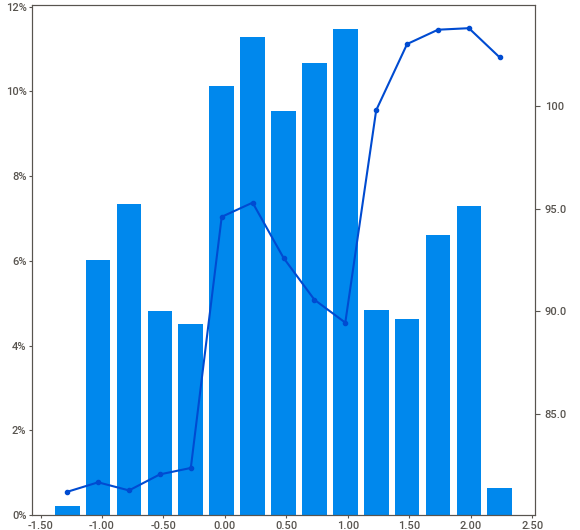
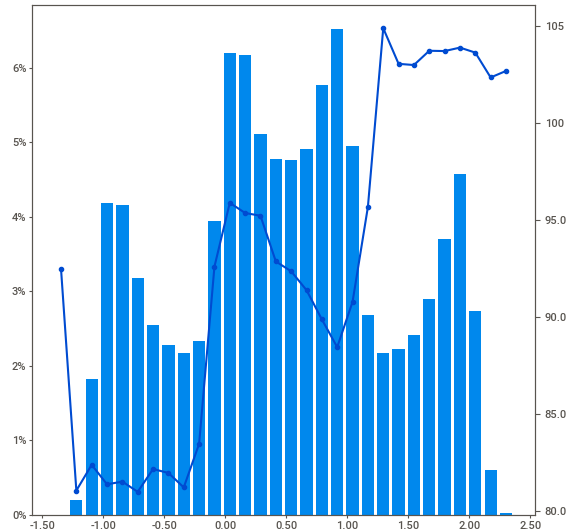
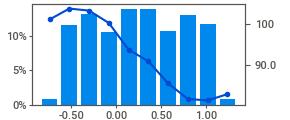
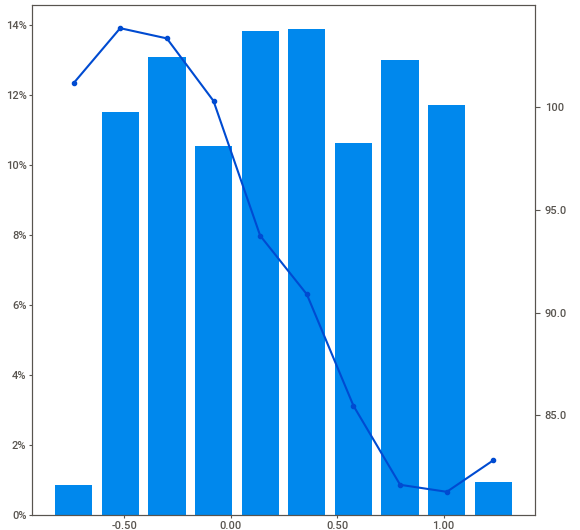
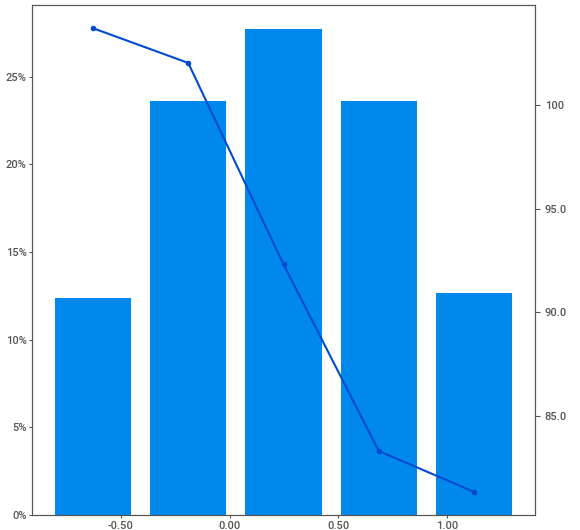
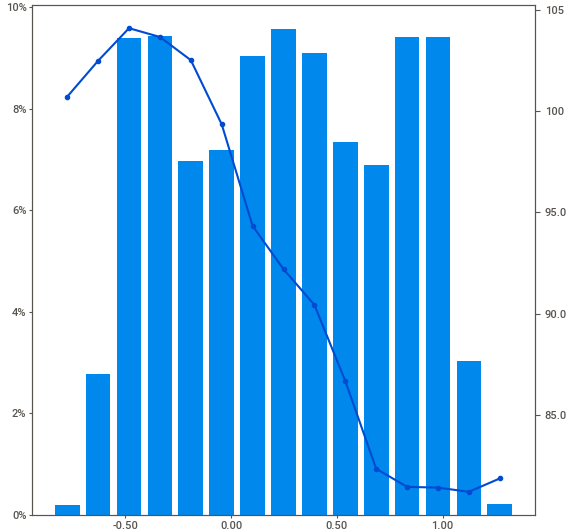
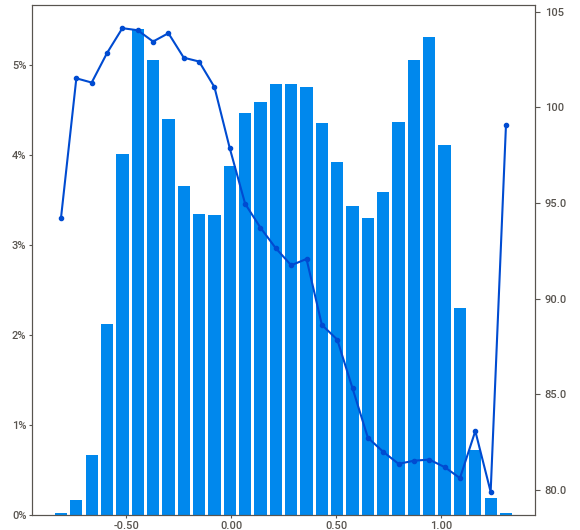
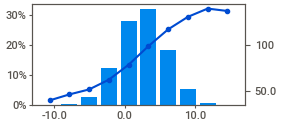
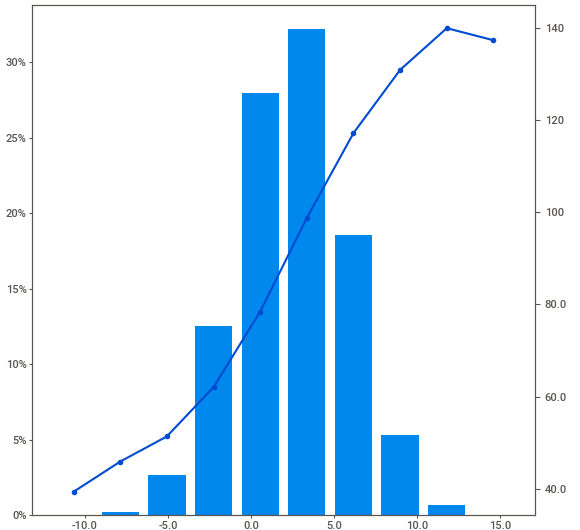
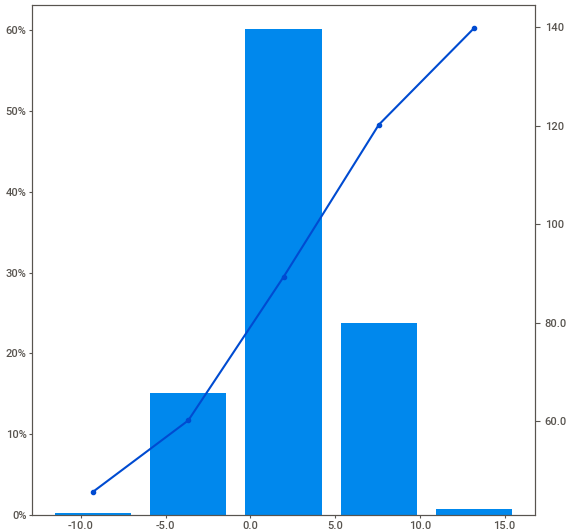
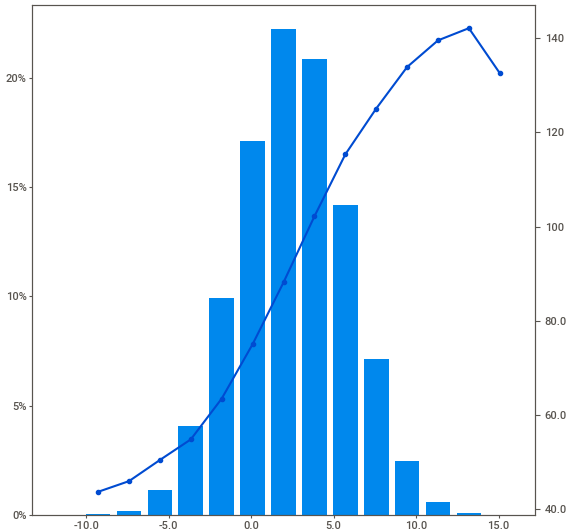
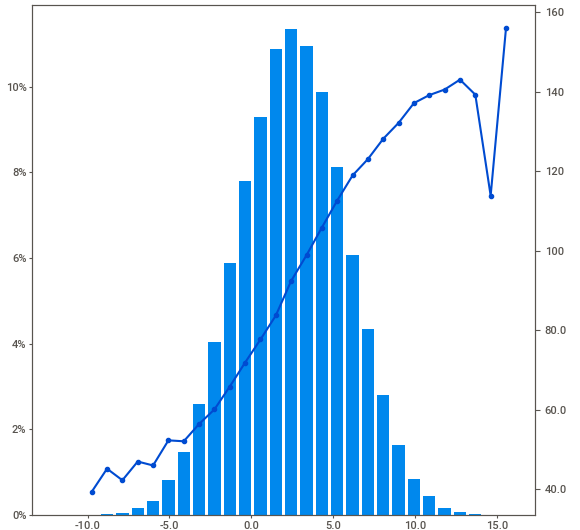
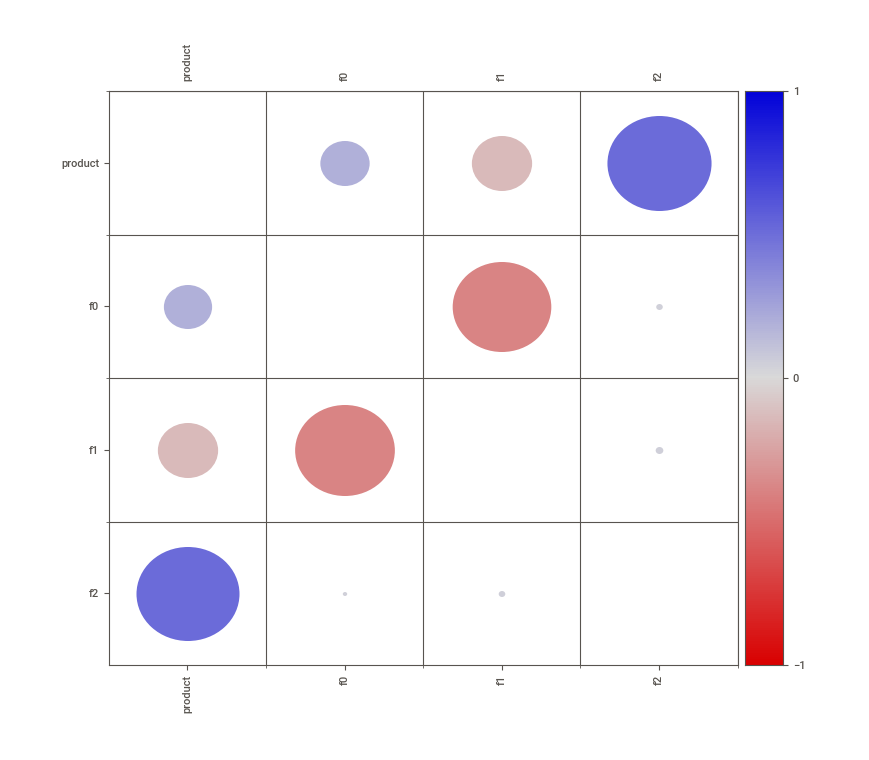
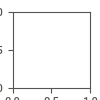

                                             |                                             | [  0%]   00:00 ->…


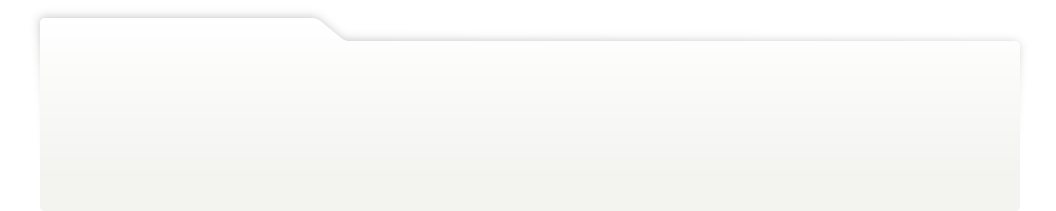
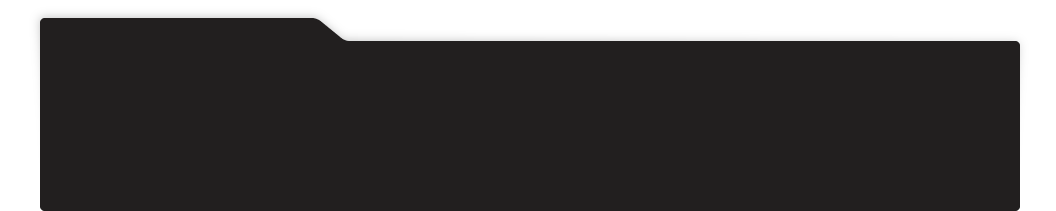
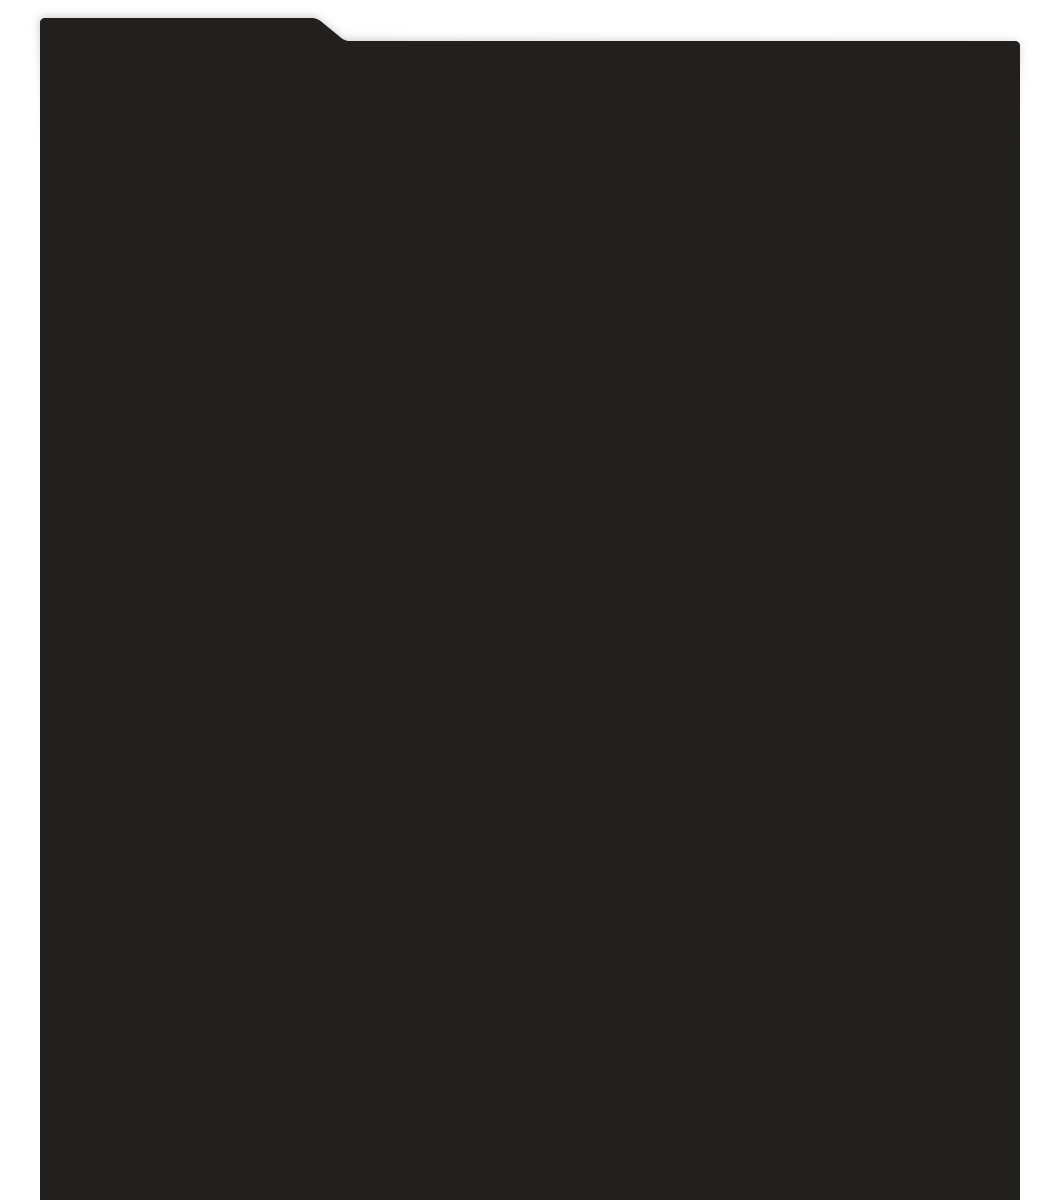
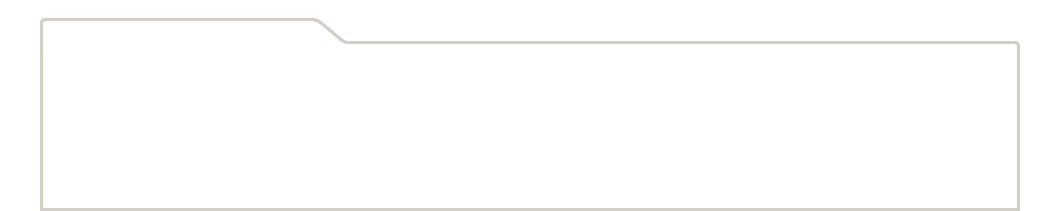
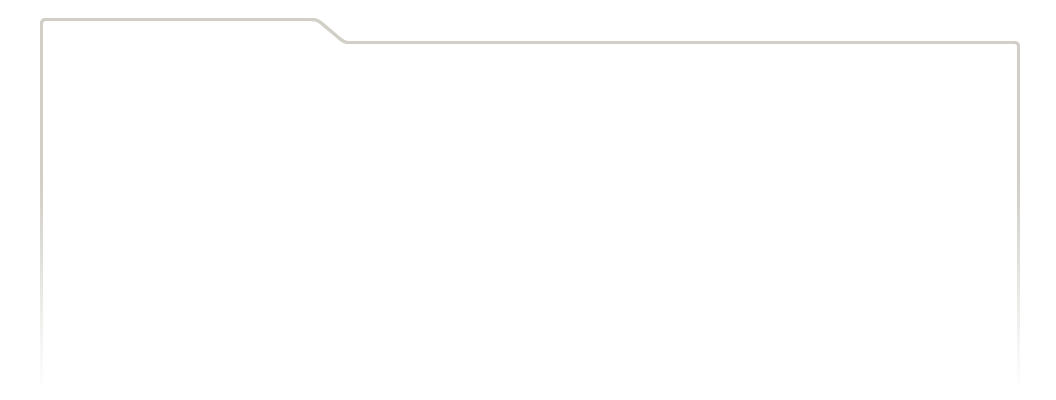
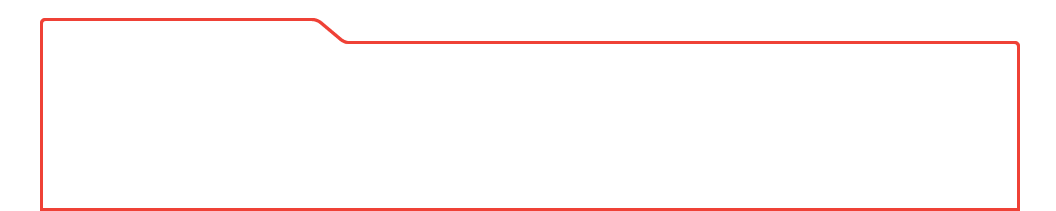
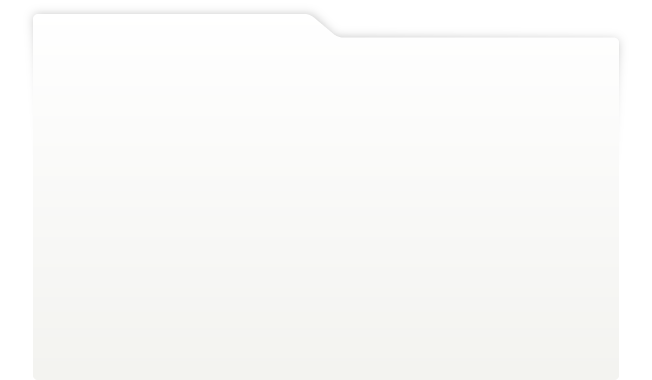
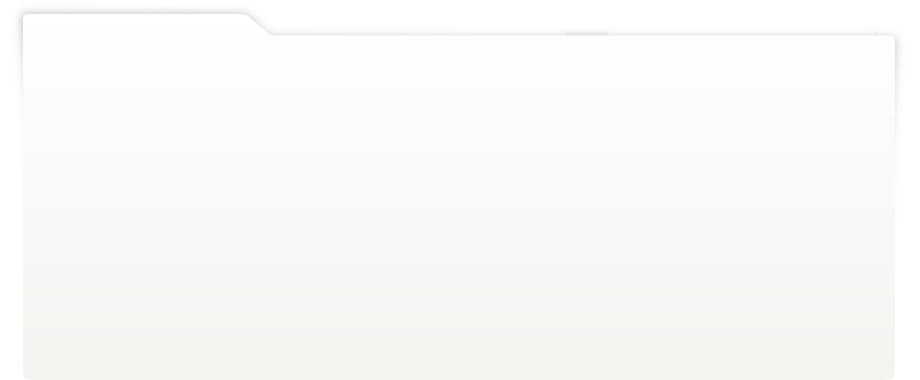
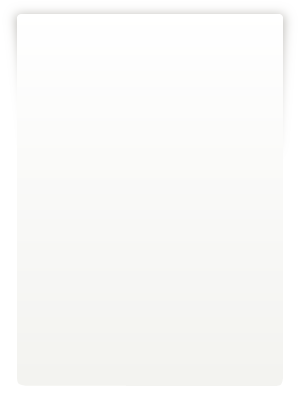
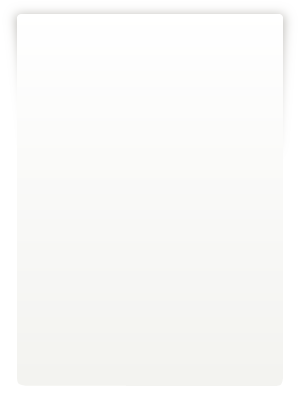
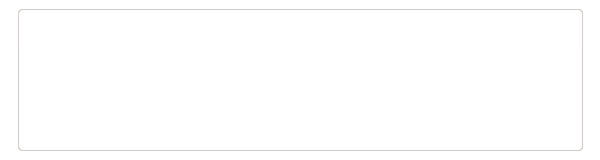
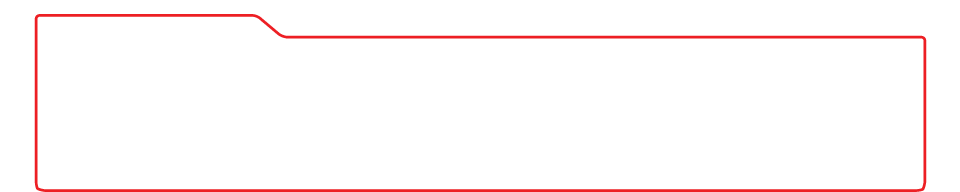
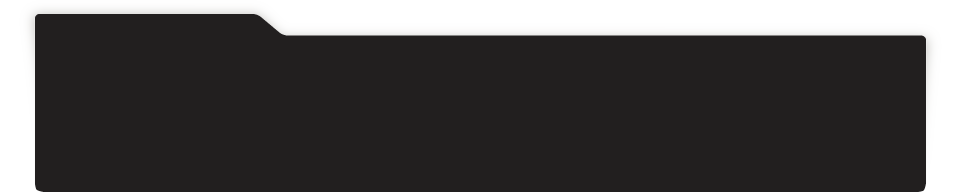
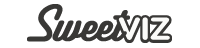
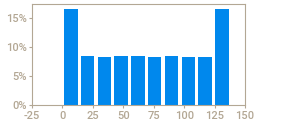
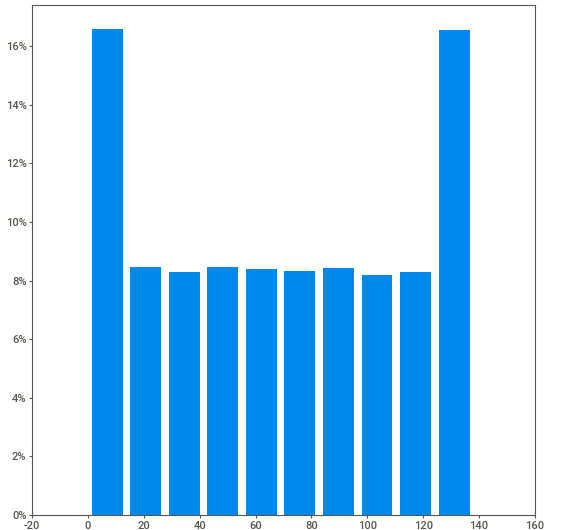
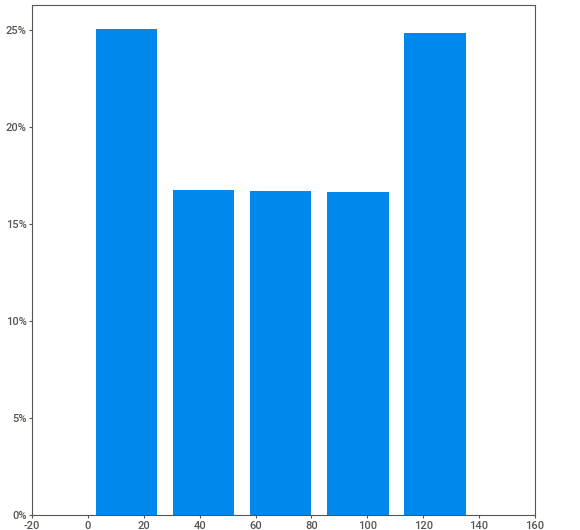
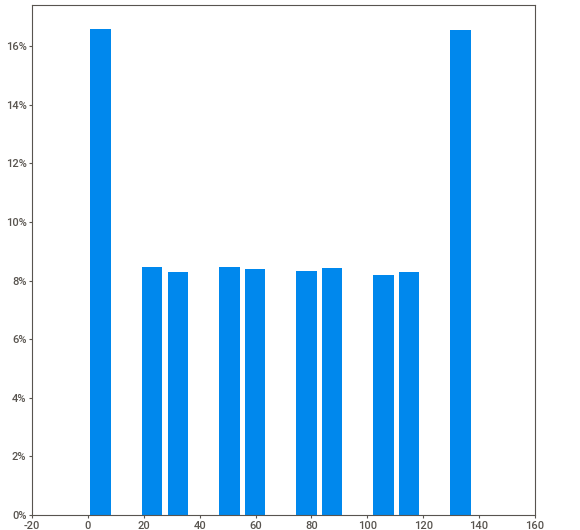
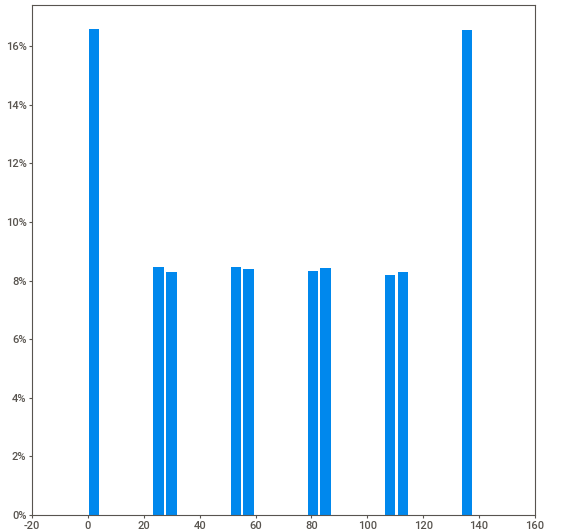
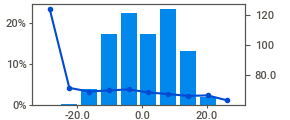
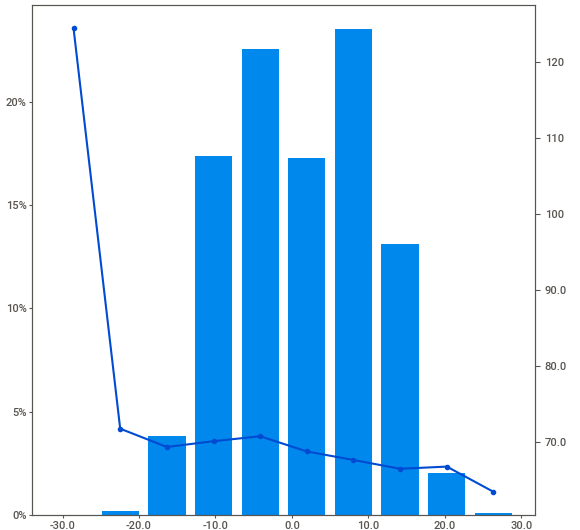
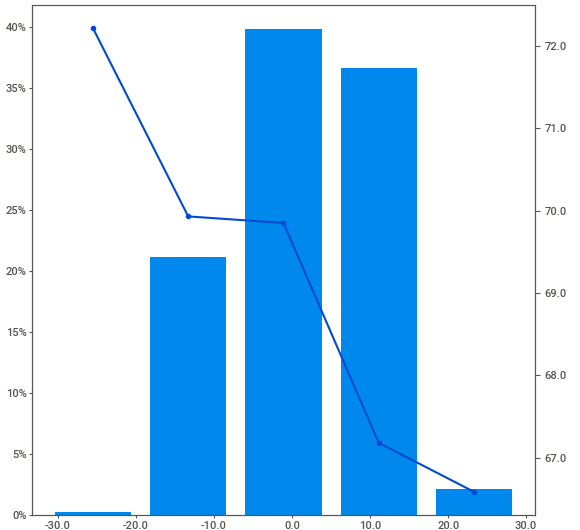
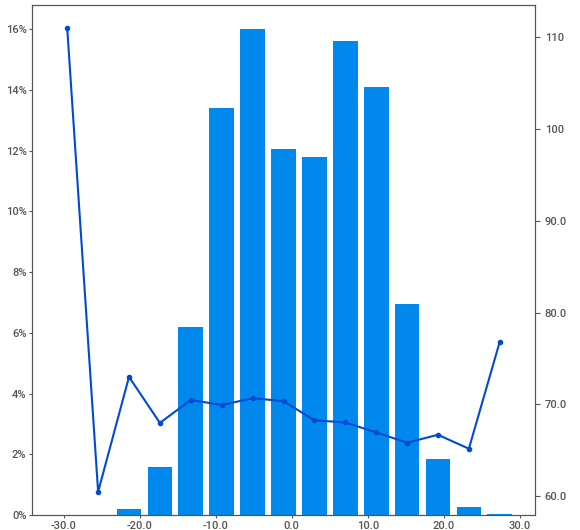
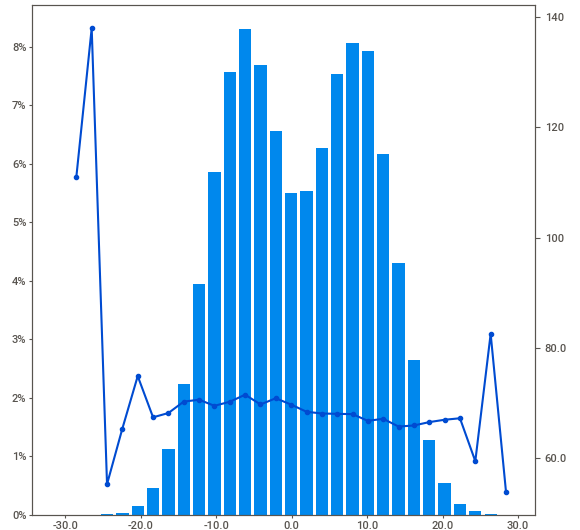
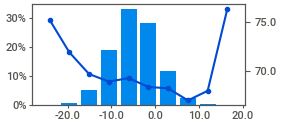
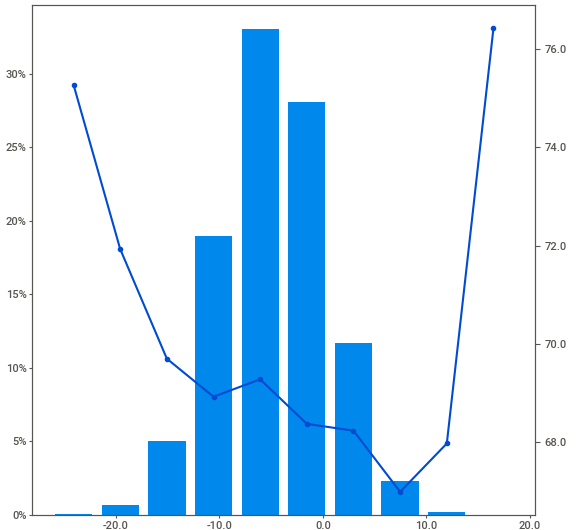
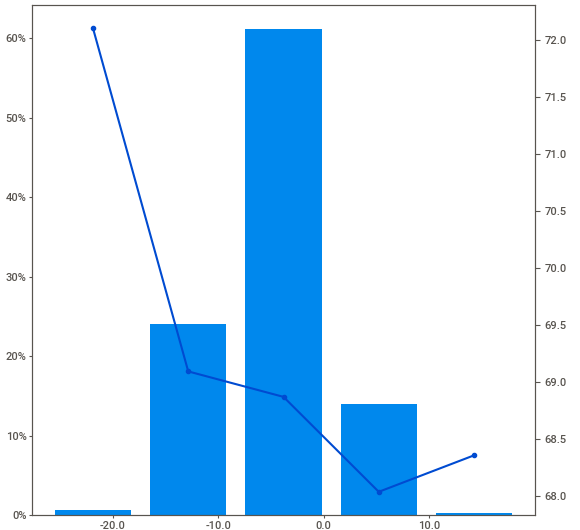
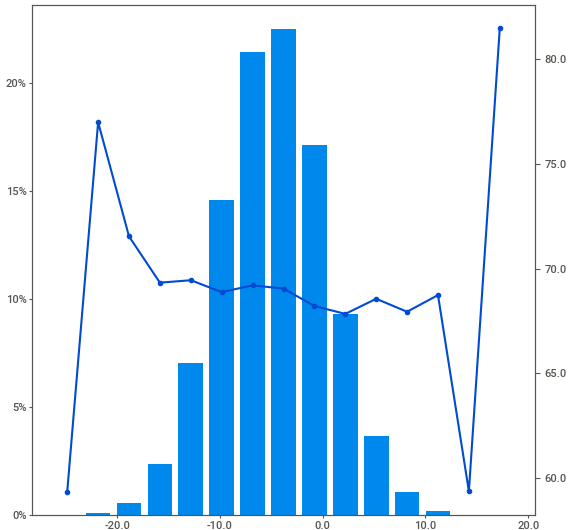
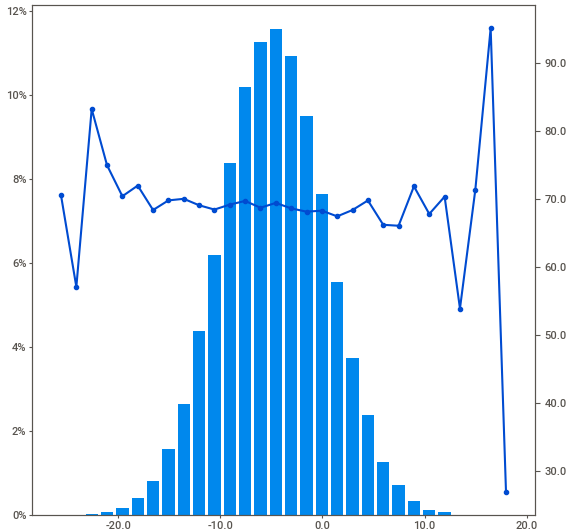
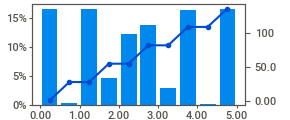
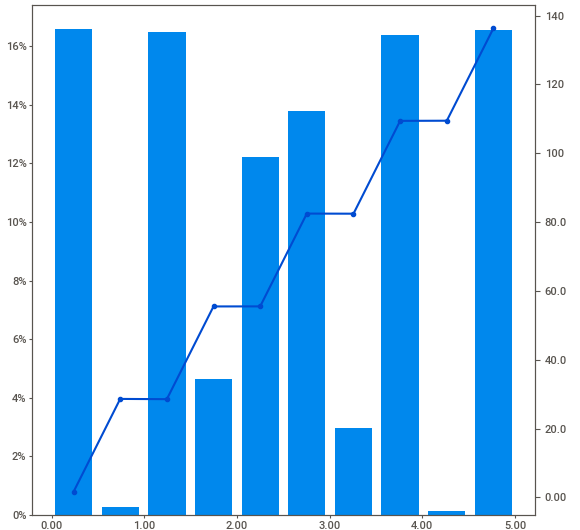
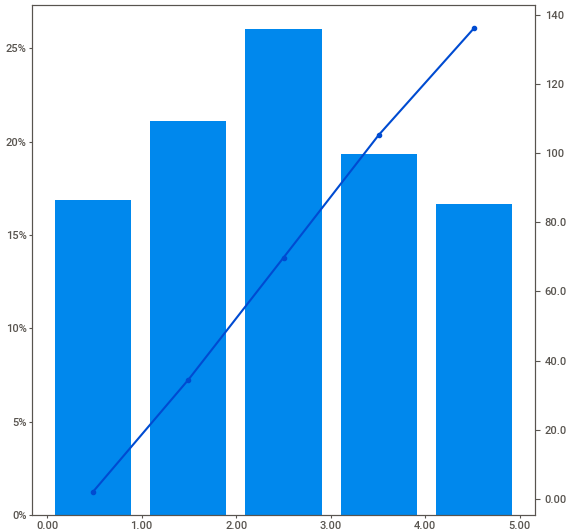
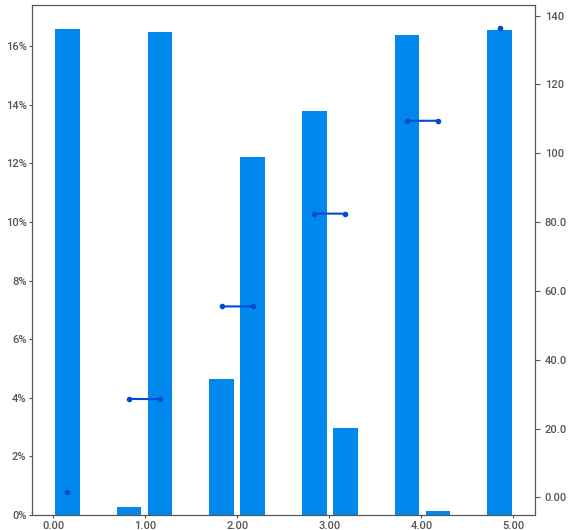
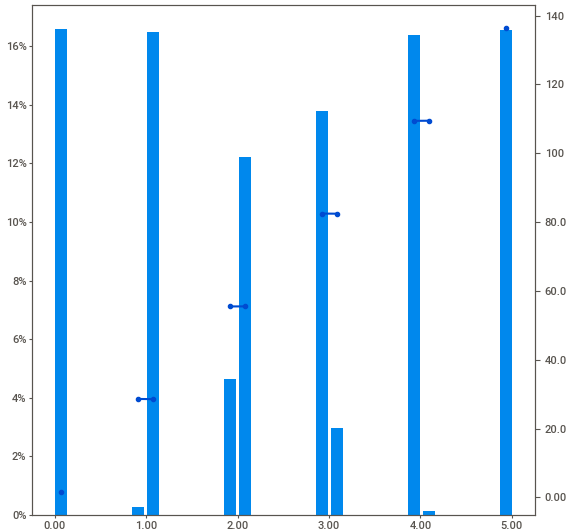
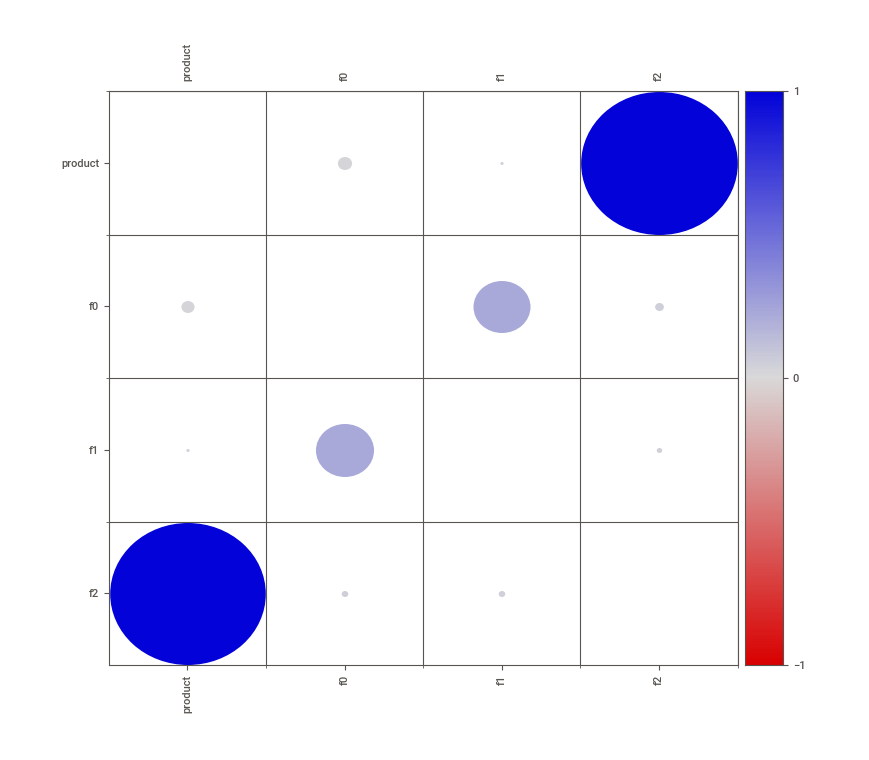
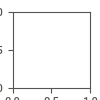

                                             |                                             | [  0%]   00:00 ->…


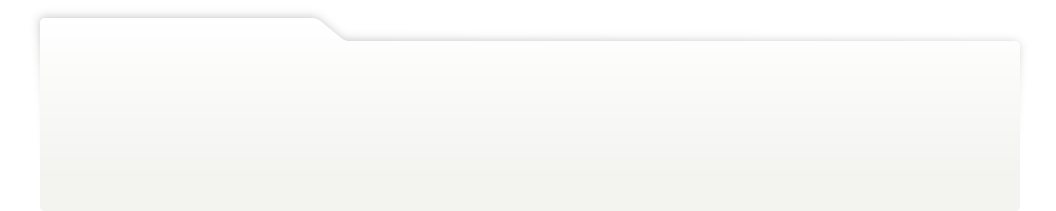
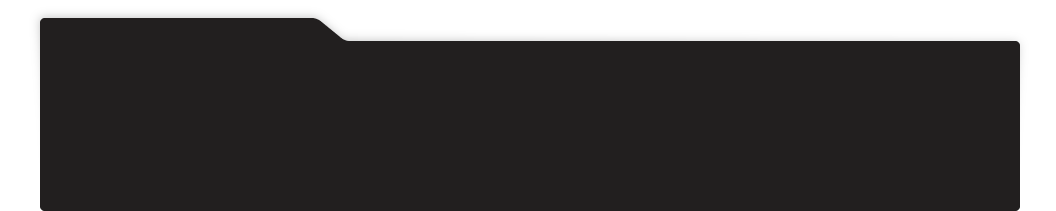
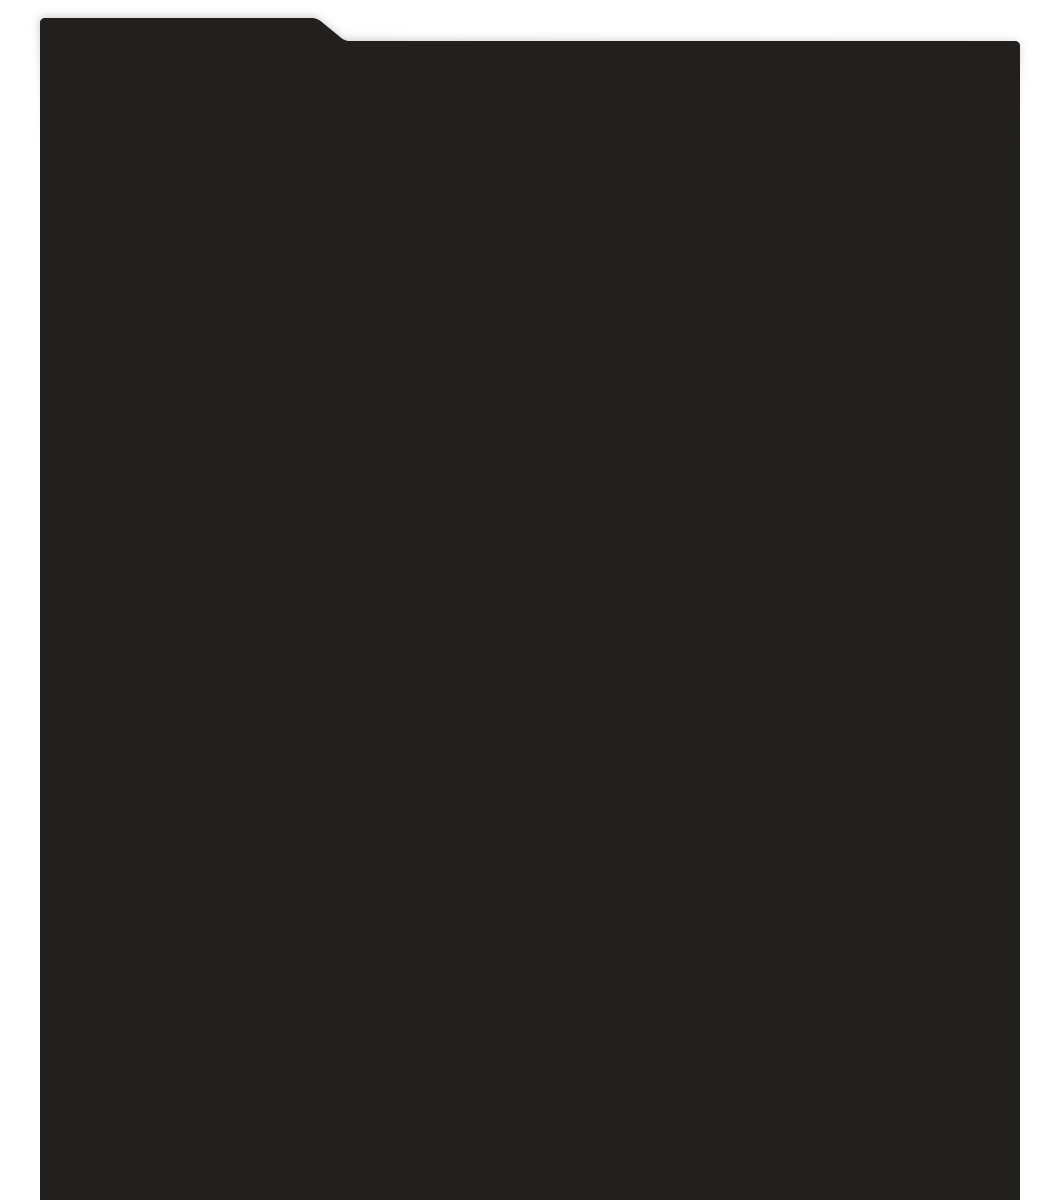
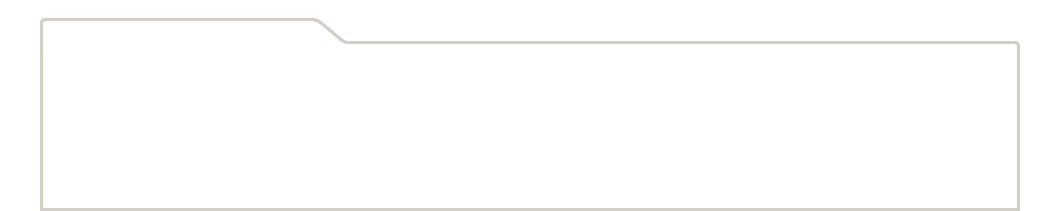
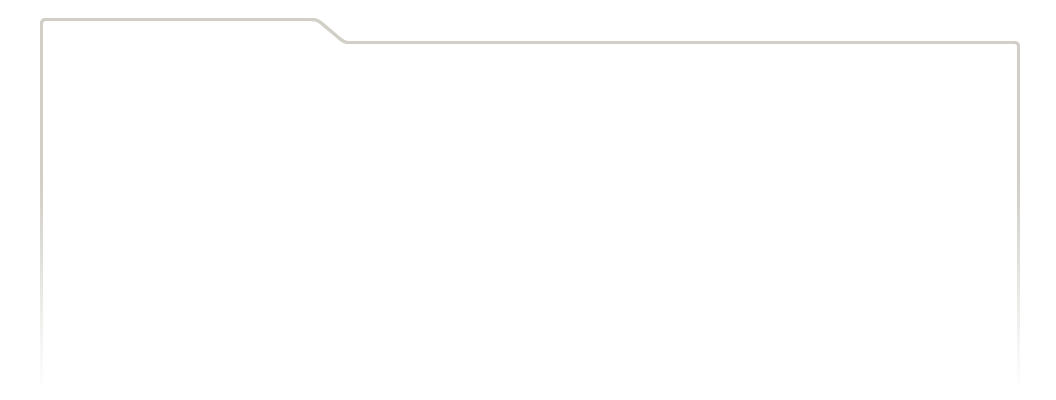
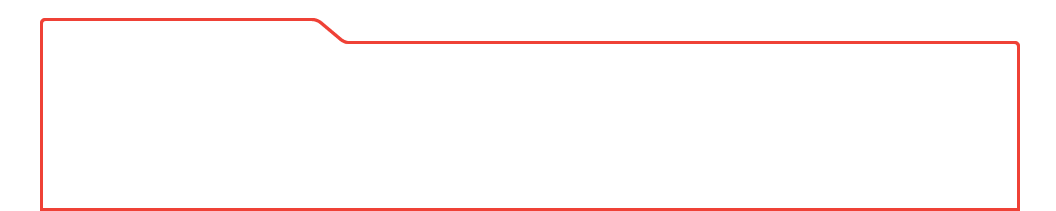
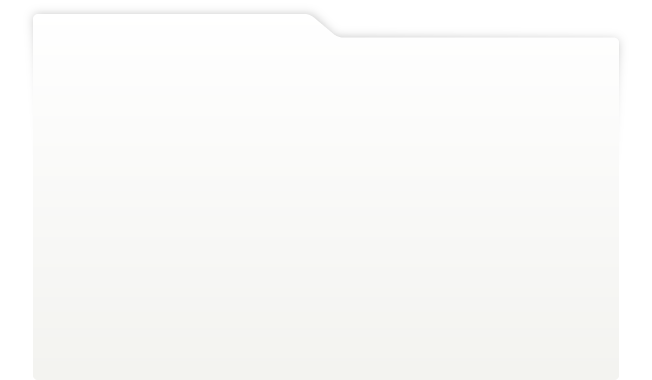
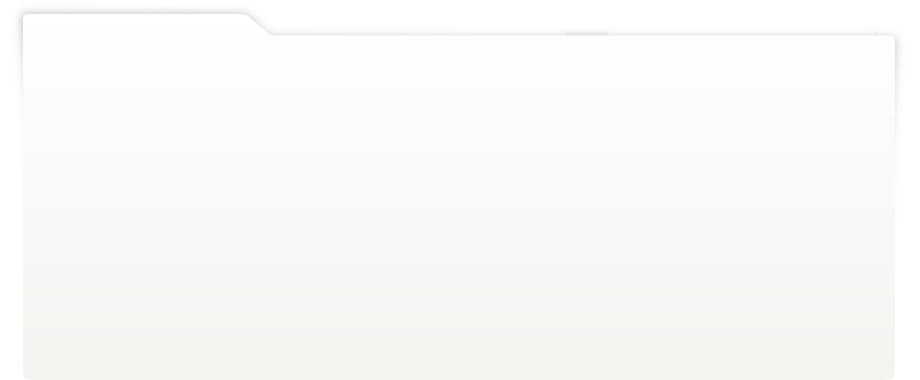
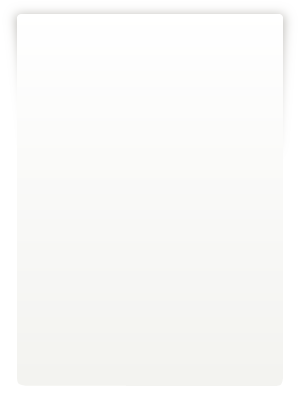
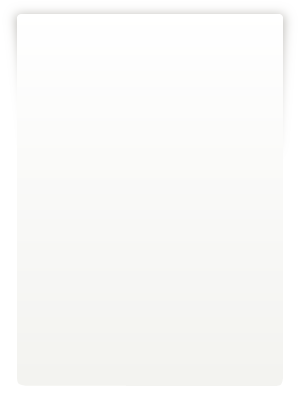
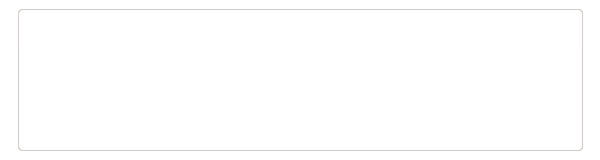
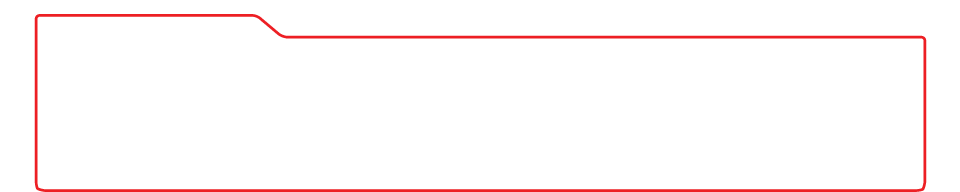
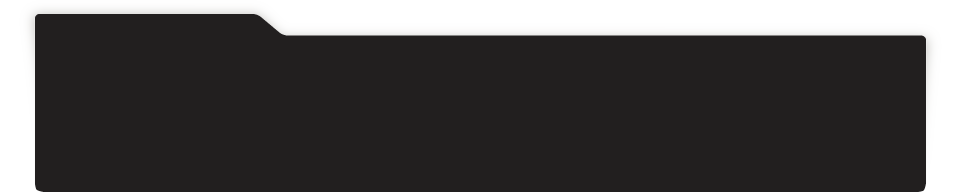
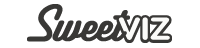
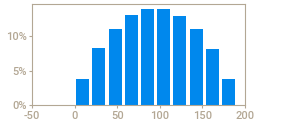
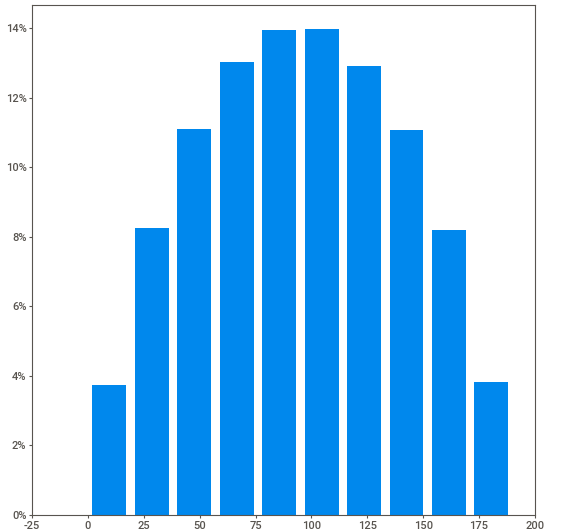
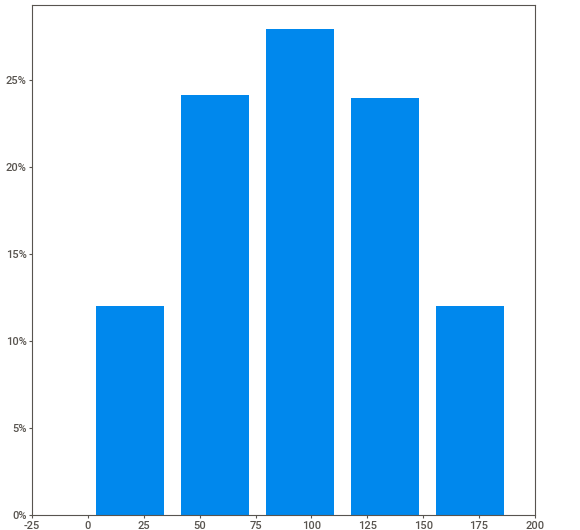
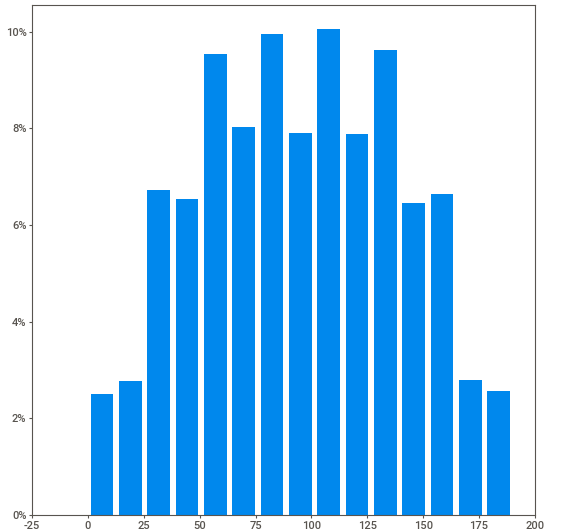
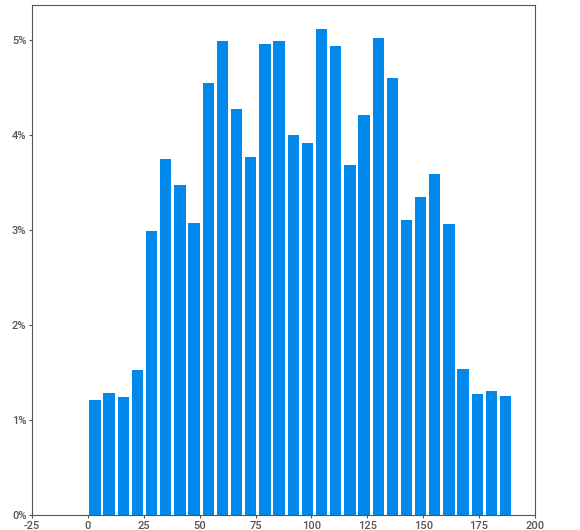
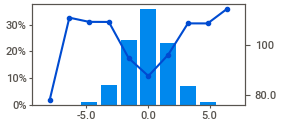
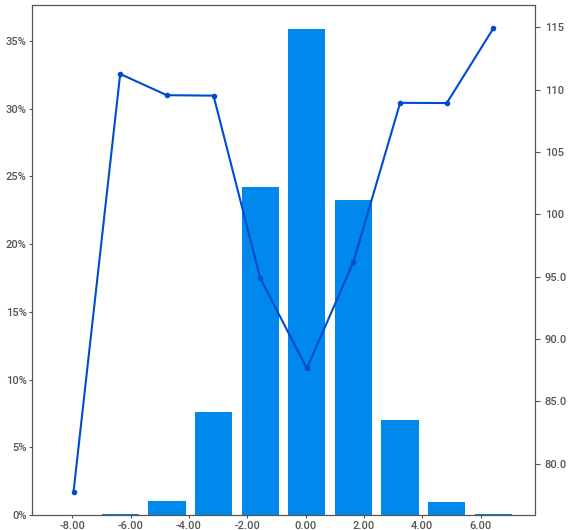
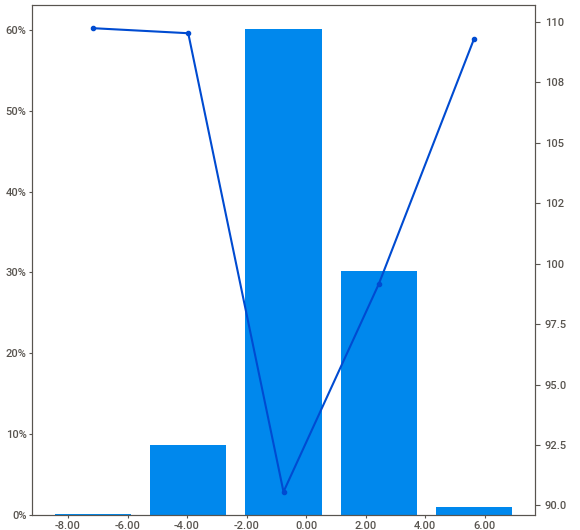
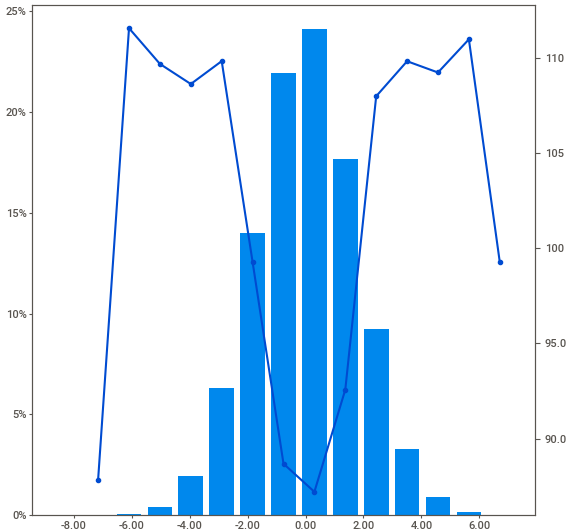
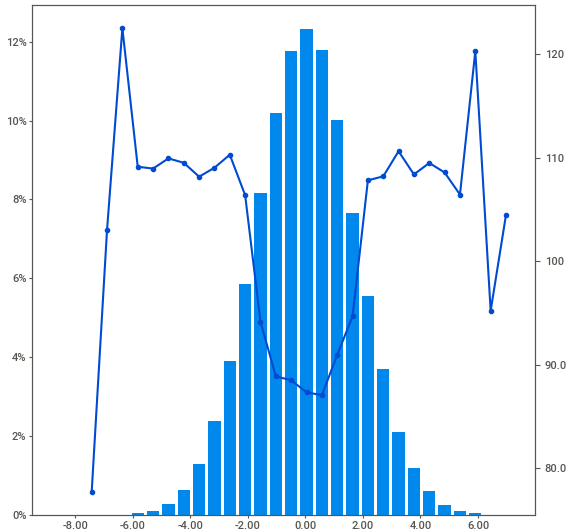
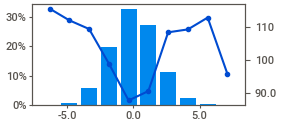
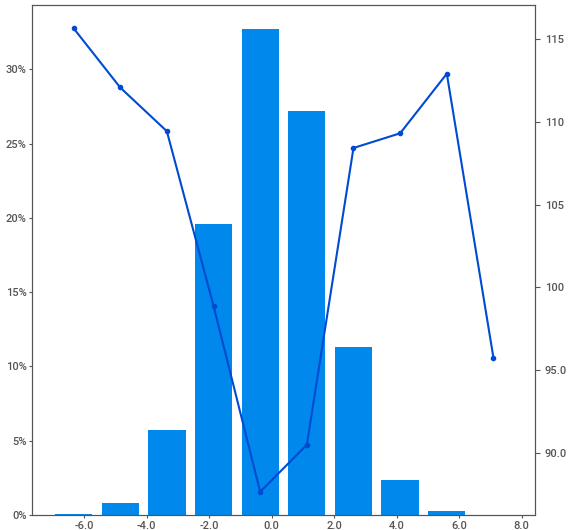
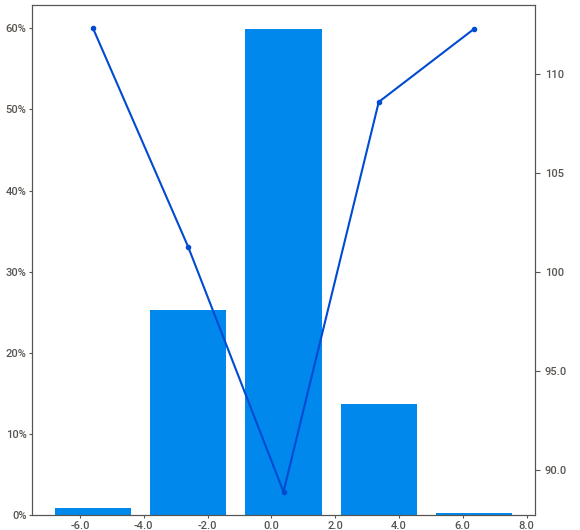
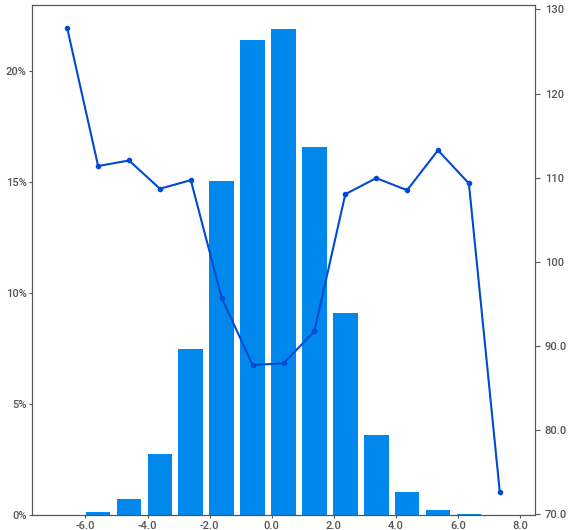
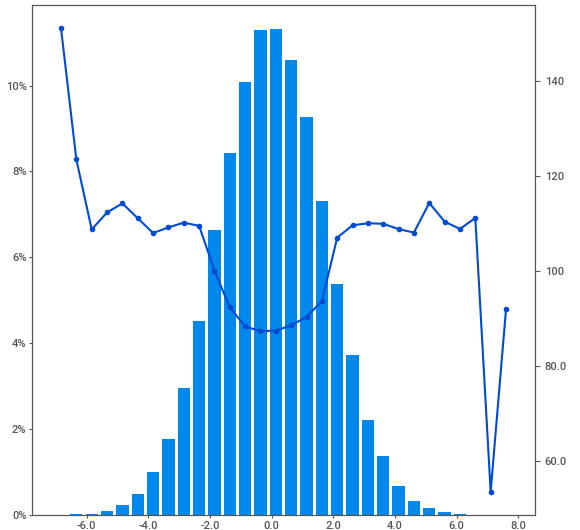
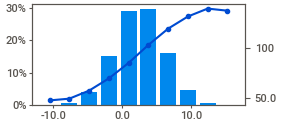
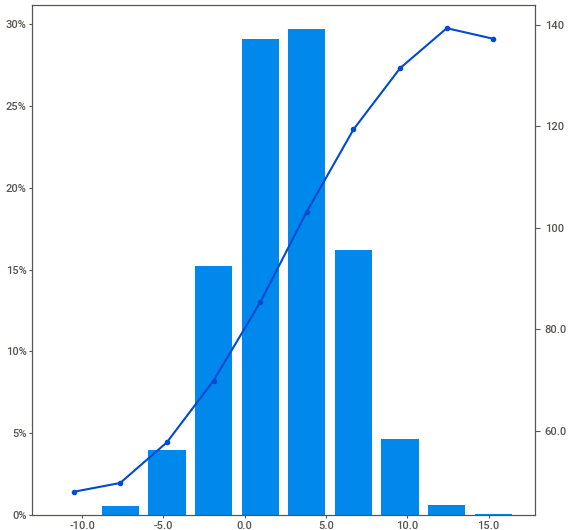
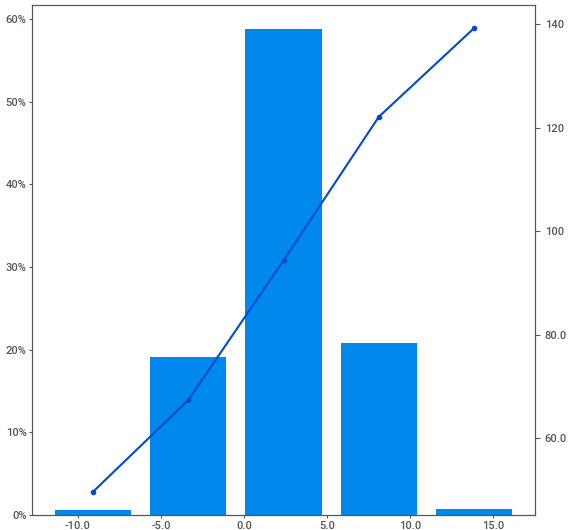
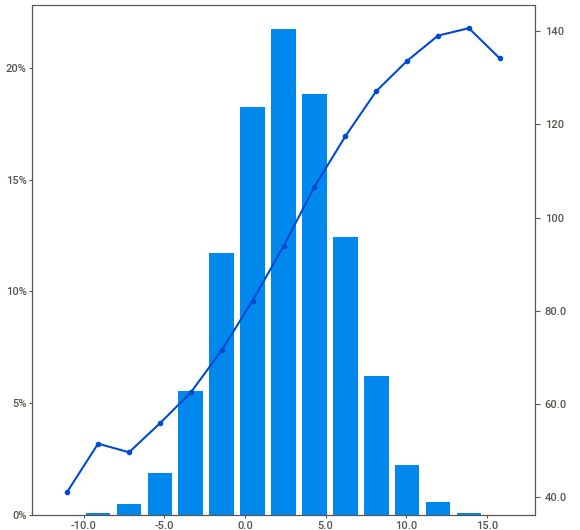
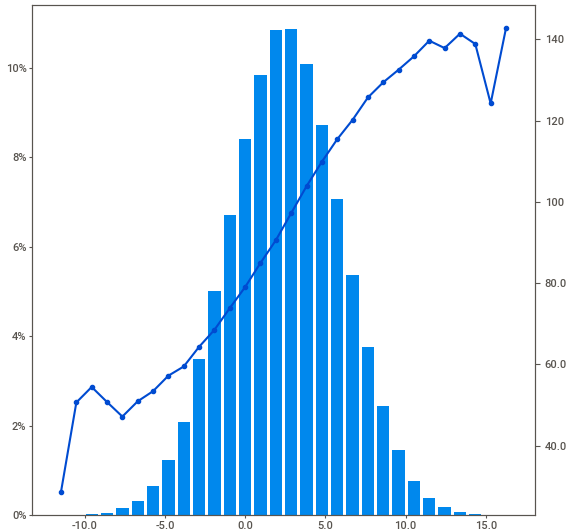
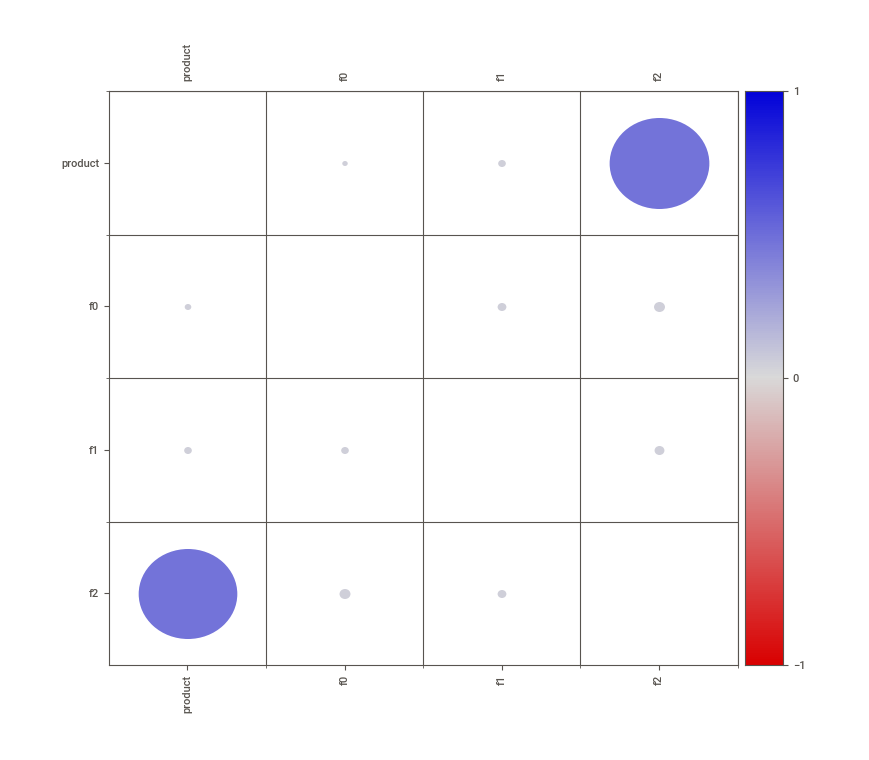
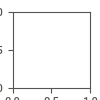

In [10]:
#анализ данных с помощью библиотеки sweetviz

# отчет по каждому из регионов    
for r in regions:
    feature_config = sv.FeatureConfig()
    my_report = sv.analyze(r, target_feat = 'product', feat_cfg = feature_config)
    my_report.show_notebook()
    

Первый регион: распределение целевого признака стремится к нормальному, среднее значение 95, стандартное отклонение 44,7. Остальные признаки распределены более хаотично, для признаков f1 и f2 выстраивается некоторая корреляция с целевым, но она не линейна. 
Второй регион: для целевого признака в этом регионе характерны выбросы в области высоких и низких значений, стандартное отклонение 45,9. При этом признаки f0 и f1 распределены близко к нормально, а f2 почти напрямую коррелирует с целевым.
Третий регион: распределение всех признаков близко к нормальному, стандартное отклонение у целевого признака 44,7, явная корреляция у целевого признака есть с признаком f2, но зависимость не линейная.

## Обучение и проверка модели

In [11]:
# разделение данных на тренировочные и валидационные
features_train_all, features_valid_all, target_train_all, target_valid_all = train_test_split(
    features_all, target_all, test_size=0.25, random_state=12345)
# по регионам
features_train = []
features_valid = []
target_train = []
target_valid = []
for i in range (len(regions)):
    features_train_i, features_valid_i, target_train_i, target_valid_i = train_test_split(
    features[i], target[i], test_size=0.25, random_state=12345)
    features_train.append(features_train_i)
    features_valid.append(features_valid_i)
    target_train.append(target_train_i)
    target_valid.append(target_valid_i)

In [12]:
#LINEARRegression
model_1 = LinearRegression()# инициализация модели логистической регрессии
model_1.fit(features_train_all, target_train_all) # обучение модели на тренировочной выборке по всем регионам
predicted_valid_all = model_1.predict(features_valid_all) # предсказания модели на валидационной выборке по всем регионам

In [13]:
print('средний запас предсказанного сырья по всем регионам', predicted_valid_all.mean())
print('средний запас сырья по всем регионам', target_all.mean())
mse = mean_squared_error(target_valid_all, predicted_valid_all)
print("RMSE =", mse ** 0.5)

средний запас предсказанного сырья по всем регионам 85.55268574023522
средний запас сырья по всем регионам 85.44166666669523
RMSE = 38.78436364859428


In [14]:
# разбивка по регионам
counter = 0 # нумерация регионов
predictions = [] # предсказания моделей
mean_real = []
mean_pred = []
rmse = []
for i in range (len(regions)): # для каждого из регионов
    model = LinearRegression()# инициализация модели логистической регрессии
    model.fit(features_train[i], target_train[i]) # обучение модели на тренировочной выборке
    predicted_valid = model.predict(features_valid[i]) # предсказания модели на валидационной выборке
    predictions.append(pd.Series(predicted_valid)) # сохраняем предсказания сразу в виде списка Series
    mean_real.append(target[i].mean())
    mean_pred.append(predicted_valid.mean())
    print('средний запас предсказанного сырья по региону', counter, ':', predicted_valid.mean())
    print('средний запас сырья по региону', counter, ':', target[i].mean())
    mse = mean_squared_error(target_valid[i], predicted_valid)
    rmse.append(mse ** 0.5)
    print("RMSE =", mse ** 0.5)
    print('R2 =', model.score(features_valid[i], target_valid[i])) 
    counter += 1

средний запас предсказанного сырья по региону 0 : 92.59256778438035
средний запас сырья по региону 0 : 92.49999999999974
RMSE = 37.5794217150813
R2 = 0.27994321524487786
средний запас предсказанного сырья по региону 1 : 68.728546895446
средний запас сырья по региону 1 : 68.82500000002561
RMSE = 0.8930992867756166
R2 = 0.9996233978805127
средний запас предсказанного сырья по региону 2 : 94.96504596800489
средний запас сырья по региону 2 : 95.00000000000041
RMSE = 40.02970873393434
R2 = 0.20524758386040443


In [15]:
region_0.corr()
#region_1.corr()
#region_2.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Выводы: В третьем регионе средний запас сырья (фактический и предсказанный) на скважину больше, чем в остальных регионах, но там и самая большая среднеквадратичная ошибка - 40 тыс. баррелей. Примечательно, что R2 метрика модели во втором регионе невероятно высокая, это говорит о высокой скоррелированности данных. При проверке матриц корреляции это подтвердилось: признак f2 почти напрямую коррелирует с запасом сырья в скважине.

## Подготовка к расчету прибыли

In [16]:
#перезапуск индексов в таргетах, чтобы они совпадали с индексами в предсказаниях
for i in range (len(target_valid)):
    target_valid[i] = target_valid[i].reset_index(drop=True) 
#средние значения по регионам и rmse уже сохранены
print(mean_real)
print(mean_pred)
print(rmse)

[92.49999999999974, 68.82500000002561, 95.00000000000041]
[92.59256778438035, 68.728546895446, 94.96504596800489]
[37.5794217150813, 0.8930992867756166, 40.02970873393434]


In [17]:
# Рассчитать достаточный объём сырья для безубыточной разработки новой скважины.
REVENUE_PER_UNIT = 450 # цена в т.р. за тысячу баррелей
NUMBER = 200 # количество скважин для разбаботки
BUDGET = 10000000 # бюджет в т.р.
# сколько в среднем тысяч баррелей должна приносить одна скважина для безубыточного производства
prod_required = BUDGET / NUMBER / REVENUE_PER_UNIT 
print(prod_required)

111.11111111111111


Согласно расчётам, если все разработанные скважины будут приносить по 111,11 тыс. баррелей, убытков не будет. Это заставляет насторожиться, т.к. это больше, чем средний объём продукции по каждому из регионов. Это значит, что придется более тщателно выбирать скважины для разработки.

## Расчёт прибыли и рисков

In [18]:
def profit(target, predictions): # здесь должны быть уже выбранные случайные скважины (500)
    preds_sorted = predictions.sort_values(ascending=False)# сортируем предсказания по убыванию
    selected = target[preds_sorted.index][:NUMBER] # выбираем 200 лучших
    return REVENUE_PER_UNIT * selected.sum() - BUDGET

#протестируем функцию на значениях первого региона
print(profit(target_valid[0], predictions[0]))


3320826.0431398507


Функция работает. Теперь нужно представить ей выборку из 500 случайных скважин из каждого региона.

In [19]:
# bootstrap    
# первый регион
state = RandomState(12345) 

values = []
for i in range(1000):
    target_subsample = target_valid[0].sample(n = 500, replace=True, random_state=state)#выбираем 500 рандомных таргетов
    probs_subsample = predictions[0][target_subsample.index] # по индексам находим для них предсказания
    values.append(profit(target_subsample, probs_subsample)) #считаем прибыль с помощью функции и добавляем в список

values = pd.Series(values)
lower = values.quantile(0.025) # выбираем 0.025 квантиль
upper = values.quantile(0.975) # выбираем 0.975 квантиль
#риск убытков считаем как долю отрицательных значений:
#risk_of_loss = values[values < 0].count() / len(values) * 100
risk_of_loss = (values < 0).mean() * 100

mean = values.mean()
print("Средняя выручка:", mean)
print("С вероятностью 97,5% выручка может быть не менее", lower)
print("С вероятностью 2,5% выручка может быть более", upper)
print('Риск убытков:',risk_of_loss, '%')


Средняя выручка: 425938.5269105926
С вероятностью 97,5% выручка может быть не менее -102090.09483793723
С вероятностью 2,5% выручка может быть более 947976.353358369
Риск убытков: 6.0 %


In [20]:
# второй регион

values = []
for i in range(1000):
    target_subsample = target_valid[1].sample(n = 500, replace=True, random_state=state)
    probs_subsample = predictions[1][target_subsample.index] 
    values.append(profit(target_subsample, probs_subsample))

values = pd.Series(values)
lower = values.quantile(0.025) # выбираем 0.025 квантиль
upper = values.quantile(0.975) # выбираем 0.975 квантиль
#риск убытков считаем как долю отрицательных значений:
risk_of_loss = (values < 0).mean() * 100

mean = values.mean()
print("Средняя выручка:", mean)
print("С вероятностью 97,5% выручка может быть не менее", lower)
print("С вероятностью 2,5% выручка может быть более", upper)
print('Риск убытков:',risk_of_loss, '%')

Средняя выручка: 518259.4936973252
С вероятностью 97,5% выручка может быть не менее 128123.23143308419
С вероятностью 2,5% выручка может быть более 953612.9820669085
Риск убытков: 0.3 %


In [21]:
# третий регион

values = []
for i in range(1000):
    target_subsample = target_valid[2].sample(n = 500, replace=True, random_state=state)
    probs_subsample = predictions[2][target_subsample.index] 
    values.append(profit(target_subsample, probs_subsample))

values = pd.Series(values)
lower = values.quantile(0.025) # выбираем 0.025 квантиль
upper = values.quantile(0.975) # выбираем 0.975 квантиль
#риск убытков считаем как долю отрицательных значений:
risk_of_loss = (values < 0).mean() * 100

mean = values.mean()
print("Средняя выручка:", mean)
print("С вероятностью 97,5% выручка может быть не менее", lower)
print("С вероятностью 2,5% выручка может быть более", upper)
print('Риск убытков:',risk_of_loss, '%')

Средняя выручка: 420194.00534405024
С вероятностью 97,5% выручка может быть не менее -115852.60916001163
С вероятностью 2,5% выручка может быть более 989629.9398445741
Риск убытков: 6.2 %


### Вывод

Результаты выглядят реалистичными. Из них можно сделать вывод, что по условию задачи подходит единственный регион - второй, т.к. в нем наибольшая предсказанная прибыль, а риск убытков менее 2,5 %.  Кроме того, анализ данных с помощью модели регресии и с применением бутстрэп дал более подробную и точную информацию, чем простое сравнение средних значений.